In [15]:
import numpy as np
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import time

# Load and preprocess the dataset from Excel
def load_and_preprocess_data(file_path):
    try:
        # Read the Excel file
        df = pd.read_excel(file_path)
        print("Successfully read Excel file")
        print(f"Columns: {df.columns.tolist()}")

        # Check which column contains text data
        text_column = None
        for col in df.columns:
            # Check if column contains text (string) data
            if df[col].dtype == 'object' or df[col].apply(lambda x: isinstance(x, str)).any():
                sample_value = df[col].dropna().iloc[0] if not df[col].dropna().empty else ""
                if isinstance(sample_value, str) and any('\u0980' <= c <= '\u09FF' for c in sample_value):
                    text_column = col
                    print(f"Using column '{text_column}' for Bangla text")
                    break

        if text_column is None:
            # If no obvious text column, try to find one with text
            for col in df.columns:
                sample_value = str(df[col].dropna().iloc[0]) if not df[col].dropna().empty else ""
                if any('\u0980' <= c <= '\u09FF' for c in sample_value):
                    text_column = col
                    print(f"Using column '{text_column}' for Bangla text (detected)")
                    break

        if text_column is None:
            raise ValueError("Could not find a column with Bangla text in the Excel file")

        # Combine all text segments
        all_text = " ".join(df[text_column].astype(str).tolist())

        # Clean the text - keep only Bangla characters, numbers, and basic punctuation
        all_text = re.sub(r'[^\u0980-\u09FF0-9\s\.\,\?\!]', '', all_text)

        # Tokenize into words
        words = all_text.split()

        return words, df, text_column

    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
        print("Using fallback sample data...")

        # Fallback sample data
        sample_text = "এরকম ঘটনা এই শহরে এর আগে ঘটেনি। তার আগে শহরটার পরিচয় দেওয়া দরকার। আমাদের চেনাশোনা আর পাঁচটা শহরের সঙ্গে এই শহরটির পার্থক্য হল এখানে আইন-শৃঙ্খলা সবাই মানে, বয়স্কদের শ্রদ্ধা করে কনিষ্ঠরা, কারণ এই শহরটিকে ওঁরা নিজেদের রক্ত দিয়েই তৈরি করেছেন বলা যায়। শহরের জন্যে প্রত্যেকেরই মায়া আছে, তাই কোনও ত্রুটিবিচ্যুতি সচরাচর চোখে পড়ে না। অথচ মাত্র পঞ্চাশ বছর এই শহরটির আয়ু। হিমালয়ের ওপর এমন টাটকা বাতাসের রাজত্বে ছবির মতো এই শহরটা দেখলে চোখ জুড়িয়ে যায়। খুব কাছের সমতলের বড় জংশন স্টেশনে পৌঁছতে বড়জোর ঘণ্টা আড়াই মতো সময় লাগে।"
        words = sample_text.split()
        return words, pd.DataFrame([sample_text], columns=['text']), 'text'

# Create sequences for training
def create_sequences(words, seq_length=5):
    sequences = []
    for i in range(seq_length, len(words)):
        seq = words[i-seq_length:i+1]
        sequences.append(" ".join(seq))
    return sequences

# Prepare the data for training
def prepare_data(sequences, tokenizer=None):
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(sequences)

    # Convert text to sequences
    sequences = tokenizer.texts_to_sequences(sequences)

    # Get vocabulary size
    vocab_size = len(tokenizer.word_index) + 1

    # Convert to numpy array
    sequences = np.array(sequences)

    # Split into input and output
    X = sequences[:, :-1]
    y = sequences[:, -1]

    # One-hot encode the output
    y = to_categorical(y, num_classes=vocab_size)

    return X, y, tokenizer, vocab_size

# Build the model
def build_model(vocab_size, seq_length, embedding_dim=100, lstm_units=150):
    print("\n" + "="*50)
    print("BUILDING MODEL ARCHITECTURE")
    print("="*50)

    model = Sequential()

    print(f"Adding Embedding layer: input_dim={vocab_size}, output_dim={embedding_dim}, input_length={seq_length}")
    model.add(Embedding(vocab_size, embedding_dim, input_length=seq_length))

    print(f"Adding Bidirectional LSTM layer: units={lstm_units}, return_sequences=True")
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))

    print("Adding Dropout layer: rate=0.3")
    model.add(Dropout(0.3))

    print(f"Adding LSTM layer: units={lstm_units}")
    model.add(LSTM(lstm_units))

    print("Adding Dropout layer: rate=0.3")
    model.add(Dropout(0.3))

    print(f"Adding Dense layer: units={lstm_units}, activation=relu")
    model.add(Dense(lstm_units, activation='relu'))

    print(f"Adding Output Dense layer: units={vocab_size}, activation=softmax")
    model.add(Dense(vocab_size, activation='softmax'))

    print("\n" + "="*50)
    print("COMPILING MODEL")
    print("="*50)
    print("Using categorical_crossentropy loss function")
    print("Using adam optimizer")
    print("Tracking accuracy metric")

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Train the model
def train_model(model, X, y, epochs=100, batch_size=64):
    print("\n" + "="*50)
    print("TRAINING MODEL")
    print("="*50)
    print(f"Training on {X.shape[0]} samples")
    print(f"Using batch size: {batch_size}")
    print(f"Maximum epochs: {epochs}")
    print("Using callbacks: EarlyStopping, ReduceLROnPlateau")

    early_stop = EarlyStopping(
        monitor='loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='loss',
        patience=5,
        factor=0.5,
        verbose=1
    )

    print("\nStarting training...")
    start_time = time.time()

    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    end_time = time.time()
    training_time = end_time - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")

    return history

# Predict next word
def predict_next_word(model, tokenizer, text, seq_length, num_predictions=3):
    # Clean the input text
    text = re.sub(r'[^\u0980-\u09FF0-9\s\.\,\?\!]', '', text)

    # Tokenize
    words = text.split()

    # Take the last seq_length words
    if len(words) > seq_length:
        words = words[-seq_length:]
    elif len(words) < seq_length:
        # Pad with empty strings if needed
        words = [''] * (seq_length - len(words)) + words

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([" ".join(words)])

    # Pad if necessary
    sequence = pad_sequences(sequence, maxlen=seq_length)

    # Predict
    prediction = model.predict(sequence, verbose=0)

    # Get top predictions
    top_indices = np.argsort(prediction[0])[-num_predictions:][::-1]

    # Convert indices to words
    word_preds = []
    for idx in top_indices:
        for word, index in tokenizer.word_index.items():
            if index == idx:
                word_preds.append(word)
                break

    return word_preds

# Main execution
def main():
    # Parameters
    SEQ_LENGTH = 5
    EPOCHS = 100
    BATCH_SIZE = 64
    EMBEDDING_DIM = 128
    LSTM_UNITS = 256

    # Load and preprocess data
    print("Loading and preprocessing data...")
    file_path = "/content/somoresh.xlsx"  # Your Excel file path
    words, df, text_column = load_and_preprocess_data(file_path)

    print(f"Loaded {len(words)} words from dataset")
    print(f"Sample words: {words[:10]}")

    # Create sequences
    sequences = create_sequences(words, SEQ_LENGTH)
    print(f"Created {len(sequences)} sequences")

    # Prepare data for training
    X, y, tokenizer, vocab_size = prepare_data(sequences)
    print(f"Vocabulary size: {vocab_size}")
    print(f"Input shape: {X.shape}, Output shape: {y.shape}")

    # Build model
    model = build_model(vocab_size, SEQ_LENGTH, EMBEDDING_DIM, LSTM_UNITS)
    print("\nModel Summary:")
    model.summary()

    # Train model
    history = train_model(model, X, y, EPOCHS, BATCH_SIZE)

    # Save history for later plotting
    with open('training_history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Save model and tokenizer for later use
    model.save('bangla_word_prediction_model.h5')
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Model training complete and saved!")

    # Interactive prediction
    print("\nWord Prediction Interface (Type 'exit' to quit)")
    while True:
        user_input = input("Enter some Bangla text: ")
        if user_input.lower() == 'exit':
            break

        if len(user_input.split()) < SEQ_LENGTH:
            print(f"Please enter at least {SEQ_LENGTH} words for better prediction.")
            continue

        predictions = predict_next_word(model, tokenizer, user_input, SEQ_LENGTH)
        print("Top predictions:", predictions)

if __name__ == "__main__":
    main()

Loading and preprocessing data...
Successfully read Excel file
Columns: ['segment_id', 'text', 'segment_type', 'metadata']
Using column 'text' for Bangla text
Loaded 2478 words from dataset
Sample words: ['এরকম', 'ঘটনা', 'এই', 'শহরে', 'এর', 'আগে', 'ঘটেনি', 'তার', 'আগে', 'শহরটার']
Created 2473 sequences
Vocabulary size: 1168
Input shape: (2473, 5), Output shape: (2473, 1168)

BUILDING MODEL ARCHITECTURE
Adding Embedding layer: input_dim=1168, output_dim=128, input_length=5
Adding Bidirectional LSTM layer: units=256, return_sequences=True
Adding Dropout layer: rate=0.3
Adding LSTM layer: units=256
Adding Dropout layer: rate=0.3
Adding Dense layer: units=256, activation=relu
Adding Output Dense layer: units=1168, activation=softmax

COMPILING MODEL
Using categorical_crossentropy loss function
Using adam optimizer
Tracking accuracy metric

Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


TRAINING MODEL
Training on 2473 samples
Using batch size: 64
Maximum epochs: 100
Using callbacks: EarlyStopping, ReduceLROnPlateau

Starting training...
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0167 - loss: 7.0359 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0222 - loss: 6.6936 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0273 - loss: 6.4945 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0270 - loss: 6.3023 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0271 - loss: 6.1248 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0249 - loss: 6.0435 - learning_rate: 0.0010
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0255 - loss: 5.8865 - learning_rate: 0.0010
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0336 - los


Training completed in 57.56 seconds
Model training complete and saved!

Word Prediction Interface (Type 'exit' to quit)
Enter some Bangla text: হঠাৎ সুর্মা বলে উঠল, জানো বাবা, 
Top predictions: ['আজ', 'মা', 'কাছে']
Enter some Bangla text: কপুর ডেভেলপমেন্ট কর্পোরেশনের সে অধিকর্তা। এই অল্পবয়সে নিজের বিদ্যাবুদ্ধির জোরে এত ভালো চাকরি পেয়েছে। সুব্রতর বাবা এই শহরের প্রথম নাগরিকদের অন্যতম। মা-মরা এই ছেলেটি এতদিন হোস্টেলে-হোস্টেলে দিন কাটিয়ে আবার নিজের শহরে ফিরে এসেছে।
Top predictions: ['ওদের', 'এসেছে', 'সামনে']
Enter some Bangla text: জমিটা পেয়ে গেছি। টাউন কমিটি স্যাংশন করেছে। শিগগির কাজ শুরু করব।
Top predictions: ['যুবক', 'খবরটা', 'তারপর']
Enter some Bangla text: exit


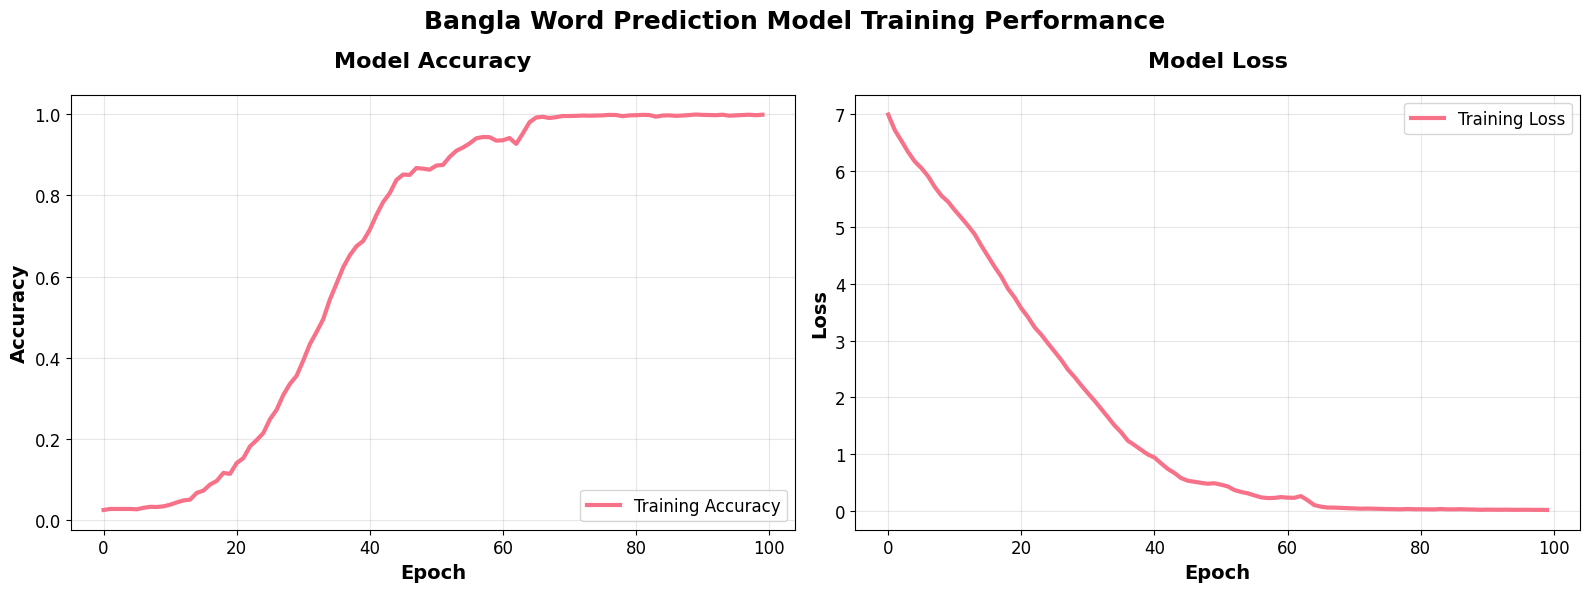

In [16]:
# Load history and plot
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the history
with open('training_history.pickle', 'rb') as handle:
    history_dict = pickle.load(handle)

# Set up the style for beautiful plots
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot training & validation accuracy values
ax1.plot(history_dict['accuracy'], linewidth=3, label='Training Accuracy')
if 'val_accuracy' in history_dict:
    ax1.plot(history_dict['val_accuracy'], linewidth=3, label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot training & validation loss values
ax2.plot(history_dict['loss'], linewidth=3, label='Training Loss')
if 'val_loss' in history_dict:
    ax2.plot(history_dict['val_loss'], linewidth=3, label='Validation Loss')
ax2.set_title('Model Loss', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Add a title for the entire figure
plt.suptitle('Bangla Word Prediction Model Training Performance', fontsize=18, fontweight='bold', y=0.98)

# Adjust layout and display
plt.tight_layout()
plt.show()